In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/utils_locate/')
from simulations.simulations import simulate_segment, simulate_data

In [3]:
purity = .9
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, purity = purity, coverage = coverage, genome_size = 30000000)
snp,snv = simulate_data(segs)

snv = snv.loc[snv['coverage'] > snv['nv']] 
take_idx = snv.index
snp = snp[snp.index.isin(take_idx)]


data_input = {'baf':torch.tensor(np.array(snp['baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(snp['dr']).reshape(-1, 1)),
              'vaf':torch.tensor(np.array(snv['nv']).reshape(-1, 1)),
              'dp':torch.tensor(np.array(snv['coverage']).reshape(-1, 1)),
              'dp_snp':torch.tensor(np.array(snp['cov']).reshape(-1, 1))}
cns = snp.CN_1

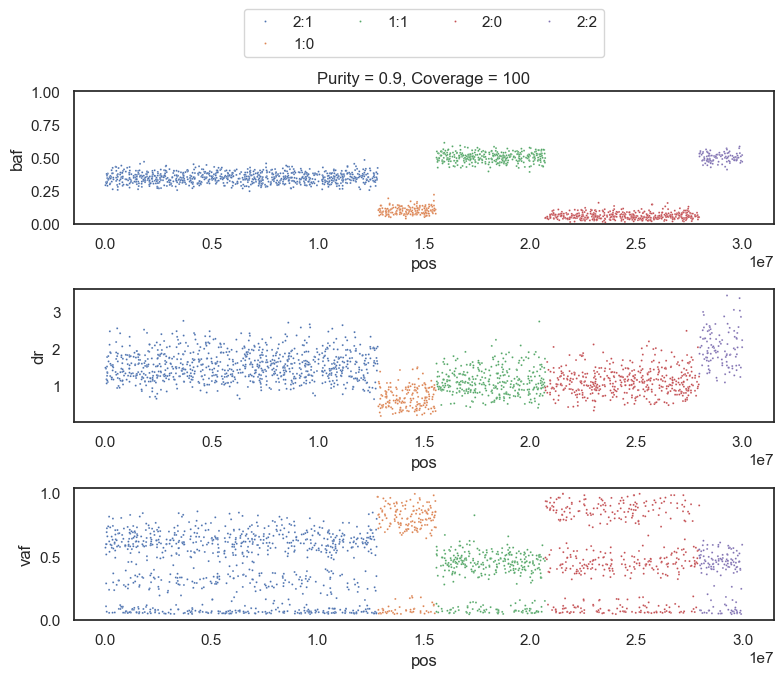

In [4]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(8, 7))

baf = sns.scatterplot(data=snp, x="pos", y="baf", s=2, ax=axes[0], hue="CN_1")
dr = sns.scatterplot(data=snp, x="pos", y="dr", s=2, ax=axes[1], hue="CN_1", legend=False)
vaf = sns.scatterplot(data=snv, x="pos", y="vaf", s=2, ax=axes[2], hue="CN_1", legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
)

axes[0].set_title(f'Purity = {purity}, Coverage = {coverage}')
fig.tight_layout()

In [5]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [6]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1]})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [13]:
ll = locate.run(steps = 600, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 7121.623750208  : 100%|██████████| 600/600 [00:09<00:00, 60.74it/s]


Done!


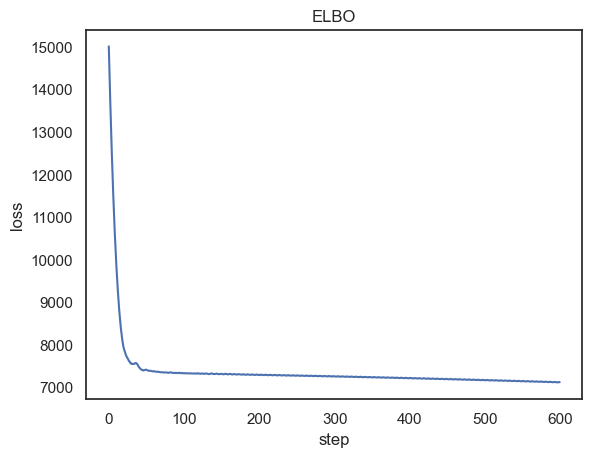

In [14]:
plot_loss(ll[0])


In [15]:
params = locate.learned_parameters_Clonal()

In [11]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

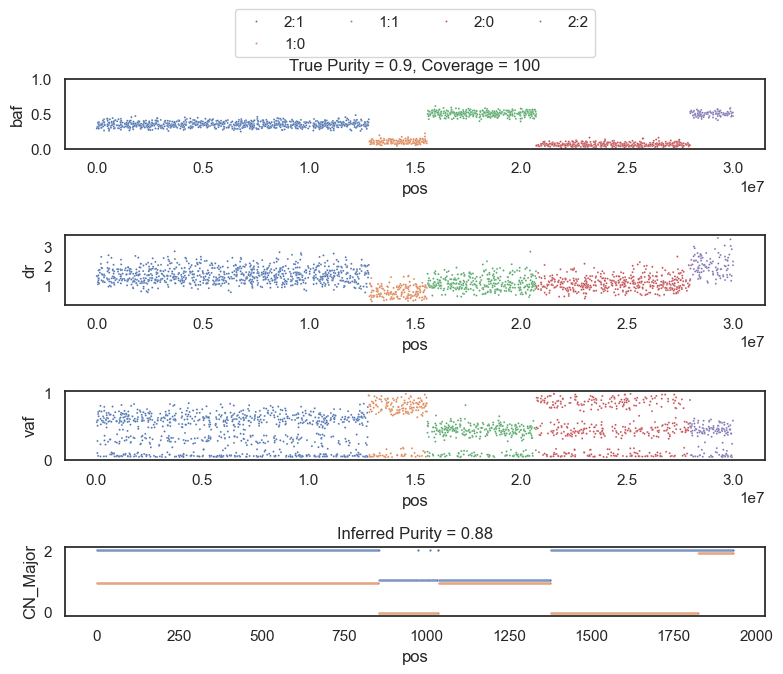

In [12]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(8, 7))

baf = sns.scatterplot(data=snp, x="pos", y="baf", s=2, ax=axes[0], hue="CN_1")
dr = sns.scatterplot(data=snp, x="pos", y="dr", s=2, ax=axes[1], hue="CN_1", legend=False)
vaf = sns.scatterplot(data=snv, x="pos", y="vaf", s=2, ax=axes[2], hue="CN_1", legend=False)

cn = sns.scatterplot(data=res, x="pos", y="CN_Major", s=2, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res, x="pos", y="CN_minor", s=2, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
)

axes[0].set_title(f'True Purity = {purity}, Coverage = {coverage}')
inf_purity = float(bau['purity'])
axes[3].set_title(f'Inferred Purity = {round(inf_purity, 2)}')
fig.tight_layout()